# Basic usage of the REVEX framework

In [66]:
import os
import numpy as np

from revex_framework.segmenters import GridSegmenter
from revex_framework.perturbers import MultiplePerturber
from revex_framework.explainers import LimeExplainer
from revex_framework.visualizers import HeatmapVisualizer
from revex_framework.pipelines import Pipeline, ProposedMethods, SeparateSpaceTimeMethods
from revex_framework.xai import Xai, XaiMerge
from revex_framework.utils import resize_video, center_crop_video, load_video, save_video, show_video, plot_frames

## Useful functions

In [utils.py](../revex_framework/utils.py), you will find several functions to facilitate video manipulation.  

It is recommended to match the shape of the video with the input layer of the network, resizing and selecting frames if necessary. This will significantly speed up the perturbation step.  

In [148]:
video_path = "../resources/blowing glass.mp4"

# Load video
video = load_video(video_path)

# Resize video
scale_factor = 224 / min(video.shape[1:3])
video = resize_video(video, scale_factor, scale_factor)

# Center crop video
video = center_crop_video(video, 224)

# Show frames
plot_frames(video, n_frames=4)

In [5]:
# Show video
show_video(video)

In [6]:
# Save video
save_path = "../temp" # Choose a path to save the video
save_video(video, save_path, "example.mp4")

## Running explanations

REVEX supports two main approaches for computing explanations:  
1. Manually selecting a segmenter, perturber, explainer, and visualizer.  
2. Using an XAI object with a specific configuration.  

### Step-by-step explanation process

#### Segmentation
The segmentation step divides the video into regions, reducing the number of features to explain. Options for this step can be found in [segmentation.ipynb](segmentation.ipynb).  

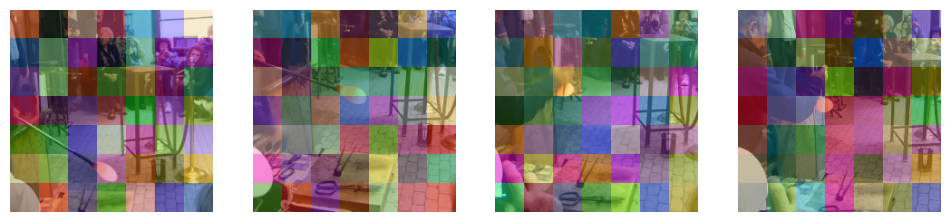

In [151]:
# Initialize segmenter
segmenter = GridSegmenter(video)

# Run segmenter
segments = segmenter.segment(n_seg=[4, 7, 7])

# Show segments
seg_video = segmenter.plot_segments(segments, kind='overlay')
plot_frames(seg_video, n_frames=4)

#### Perturbation

This step perturbs the regions defined during segmentation and processes the perturbed samples through the network. Options for this step can be found in [feature selection.ipynb](<feature selection.ipynb>) and [feature removal.ipynb](<feature removal.ipynb>).  

In [152]:
def classifier_fn(batch):
    """ Classifier function that returns the predictions for the input batch. 
    
    Args:
        batch (np.array): Batch of videos to predict.

    Returns:
        preds (np.array): Predictions for the input batch.
    """
    preds = [] # Put here your call to the classifier
    return np.array(preds)

# Initialize perturber
perturber = MultiplePerturber(video, segments, classifier_fn, hide_color='blur') 

# Run perturber
# It is possible to use the save_videos_path and dont_predict arguments to save 
# the perturbed videos and avoid calling the classifier for higher speed.
data, labels = perturber.perturb(num_samples=1000, blur_mode='2d', blur_radius=10)

  0%|          | 0/1001 [00:00<?, ?it/s]

#### Explanation

Select a summarization technique to compute an explanation from the data and labels generated in the perturbation step.

In [153]:
# Initialize explainer
explainer = LimeExplainer(data, labels)

# Run explainer
# You can choose the label to explain by setting the label_to_explain argument, or you
# can let it as None to explain the label with highest prediction score.
score = explainer.explain()

#### Visualization

Visualize the explanations using different options to enhance their clarity.  

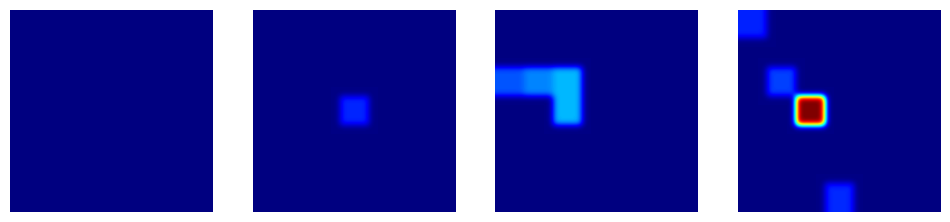

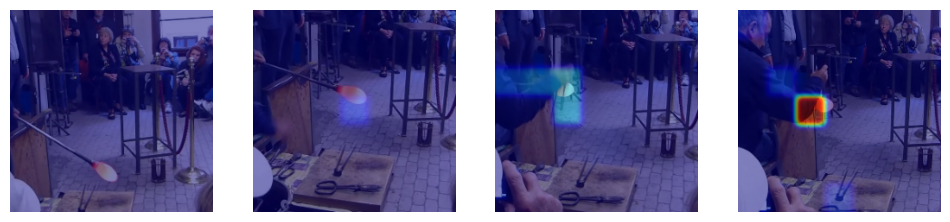

In [154]:
# Initialize visualizer
visualizer = HeatmapVisualizer(video, segments, score)

# First compute the importance of each segment.
# You can try different options for the arguments to improve the visualization.
# Values used for blurring should be chosen according to the perturber.
score_map = visualizer.get_score_map(pos_only=True, min_accum=0.3, improve_background=True,
                                     blur_mode='2d', blur_radius=10)

# Compute a visualization of the importance scores. 
# In this case the result is a heatmap.
rgb_score_map = visualizer.visualize(score_map)
plot_frames(rgb_score_map, n_frames=4)

# Merge the heatmap with the input video.
exp_vid = visualizer.visualize_on_video(rgb_score_map)
plot_frames(exp_vid, n_frames=4)

### Using a configuration

The options for each explanation step can be defined through multiple dictionaries, forming a pipeline that is executed via an XAI object.  

In [155]:
def classifier_fn(batch):
    """ Classifier function that returns the predictions for the input batch. 
    
    Args:
        batch (np.array): Batch of videos to predict.

    Returns:
        preds (np.array): Predictions for the input batch.
    """
    preds = [] # Put here your call to the classifier
    return np.array(preds)

# Choose the options for each step
seg={
    'type': 'grid',
    'n_seg': [4, 7, 7]}
per={
    'type': 'multiple',
    'hide_color': 'blur', 
    'blur_mode': '2d', 
    'blur_radius': 10,
    'num_samples': 1000}
exp={
    'type': 'lime',
    'kernel': 'lime'}
vis={
    'type': 'heatmap',
    'pos_only': True,
    'min_accum': 0.3,
    'improve_background': True,
    'blur_mode': '2d',
    'blur_radius': 10}

# Initialize pipeline
pipeline = Pipeline(seg, per, exp, vis)

# Initialize XAI object
xai = Xai(video, classifier_fn, pipeline)

# Run the whole explanation process
xai.run_pipeline(verbose=True)

segmenting, type: grid
perturbing, type: multiple


  0%|          | 0/1001 [00:00<?, ?it/s]

explaining, type: lime
visualizing, type: heatmap


Results are stored in the xai object:

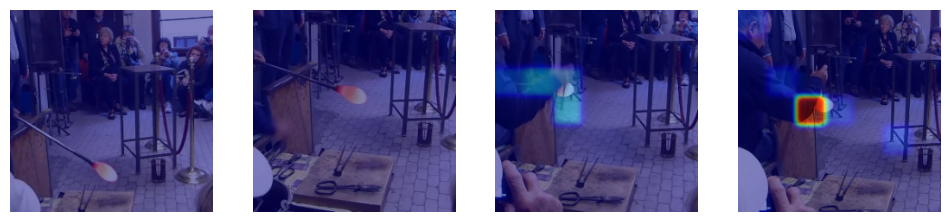

In [156]:
# Segmentation
segmenter = xai.segmenter
segments = xai.segments

# Perturbation
perturber = xai.perturber
data = xai.data
labels = xai.labels

# Explanation
explainer = xai.explainer
scores = xai.scores

# Visualization
visualizer = xai.visualizer
score_map = xai.score_map
rgb_score_map = xai.rgb_score_map
exp_vid = xai.exp_vid

plot_frames(exp_vid, n_frames=4)

You can also use the proposed pipelines to extend common removal-based methods from image-based inputs:

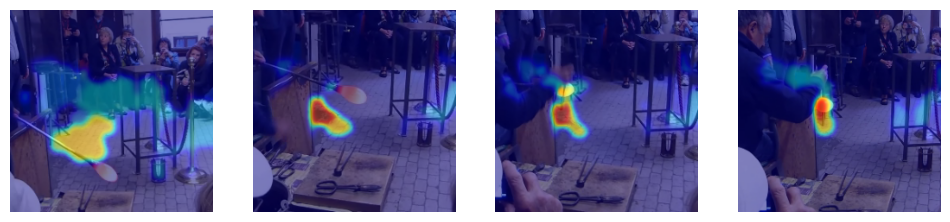

In [150]:
xai = Xai(video, classifier_fn, ProposedMethods.VideoLIME)
xai.run_pipeline()
save_video(xai.exp_vid, save_path, 'VideoLIME.m4v')
plot_frames(xai.exp_vid, n_frames=4)

See the remaining pipelines in [explanation.ipynb](<explanation.ipynb>).

## Merging explanations

You can merge multiple explanations using an XaiMerge object by passing multiple pipelines to it. The partial explanations are combined into a single explanation based on the configuration for the merged outputs. Merging explanations is particularly useful for observing the relevance across different dimensions.

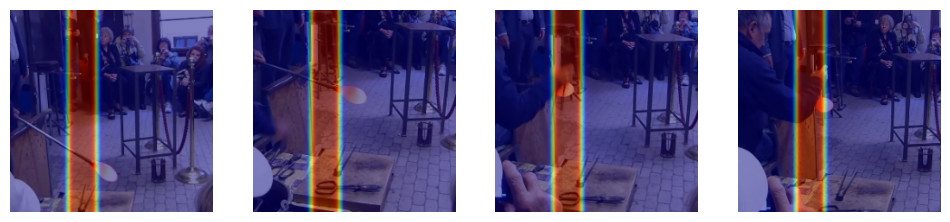

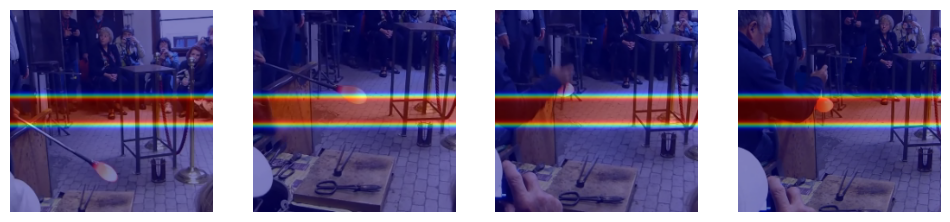

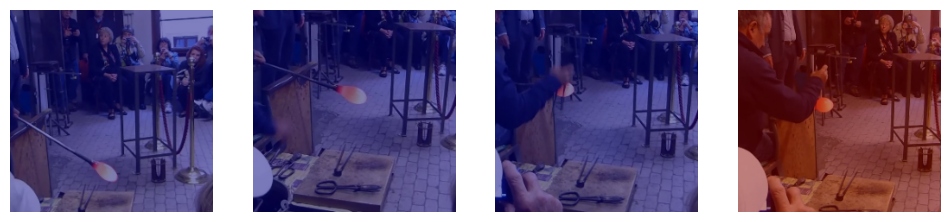

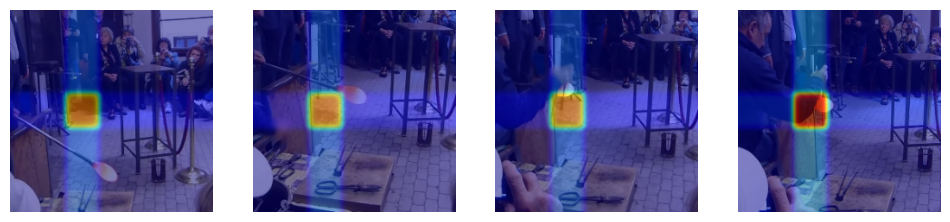

In [159]:
# Define the visualization of the merged explanations
vis_merged_dict = SeparateSpaceTimeMethods.SpaceX_LIME_blur.vis
vis_merged_dict['alpha_list'] = [1, 1, 1]
vis_merged_dict['mean_type'] = 'harmonic'

# Run pipelines and merge results
xai = XaiMerge(
    video, 
    classifier_fn, 
    [SeparateSpaceTimeMethods.SpaceX_LIME_blur, SeparateSpaceTimeMethods.SpaceY_LIME_blur, SeparateSpaceTimeMethods.Time_LIME_blur], 
    vis_merged_dict, 
    show_progress=True)
xai.run_pipeline(verbose=True)
save_video(xai.exp_vid, os.path.join(save_path, 'merged_grid_blur.m4v'))

# Save also partial explanations
for i, x in enumerate(xai.xais):
    x.visualize()
    save_video(x.exp_vid, os.path.join(save_path, f'grid_blur_{i}.m4v'))
    plot_frames(x.exp_vid, n_frames=4)
plot_frames(xai.exp_vid, n_frames=4)

## Evaluation metrics

REVEX also implements multiple evaluation metrics that can be used to compare XAI methods. The evaluation metrics can be grouped into:

1. Deletion and Preservation Games-based metrics.
2. Weakly supervized object localization metrics, which require object detection annotations.

They are explained in the detail in [evaluation.ipynb](evaluation.ipynb)